# Support Proxy Quantitative Analysis
What kind of conclusions can we draw from/into the CSCW work involving our meaningful support classifier?

In [10]:
%matplotlib inline

from pathlib import Path
import os
import subprocess

import pandas as pd
import numpy as np

from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl

import sklearn
import sklearn.model_selection
import sklearn.linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

In [11]:
author_type_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/author_type"
support_m_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/support_modeling"
site_patient_proportions_filepath = os.path.join(author_type_dir, 'site_patient_proportions.df')
site_author_type_df = pd.read_feather(site_patient_proportions_filepath)
len(site_author_type_df)

340414

In [12]:
site_to_type = {x: y for x, y in zip(site_author_type_df.site_id, site_author_type_df.site_author_type)}

In [13]:
def I(x):
    return x

In [14]:
import joblib

model = joblib.load(os.path.join(support_m_dir, "support_classifier.sav"))

In [15]:
# = pd.read_hdf(os.path.join(support_m_dir, "tokenized_for_bf.h5"))

In [16]:
import spacy
nlp = spacy.load('en_core_web_lg')
output_data_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/support_modeling"

In [17]:
gbs = pd.read_hdf('pbs/with_text_for_classify.h5')
gbs = gbs.sample(n=1000000)

tokens = []
for doc in tqdm(nlp.pipe([x if x != None else "" for x in gbs.body_text], batch_size=20000, n_threads=16), total=len(gbs), position=False):
    tokens.append([token.text for token in doc])
gbs['tokens'] = tokens

gbs['tokens'] = gbs['tokens'].map(list)
gbs['body_text'] = gbs['body_text'].map(str)
gbs['int_type'] = gbs['int_type'].map(str)
gbs['journal_oid'] = gbs['journal_oid'].map(str)

100%|██████████| 1000000/1000000 [2:47:44<00:00, 99.36it/s]   


In [18]:
ready = gbs
ready['type_label'] = [site_to_type[x] for x in ready.site_id]
labeled = ready.drop(['journal_oid', 'site_index', 'is_nontrivial', 'is_self_interaction'], axis=1)
labeled.head()

,user_id,site_id,int_type,created_at,updated_at,body_text,tokens,type_label
839347,3615759,151556,guestbook,1340119080000,1340119080000,Positive thoughts beaming your way! Remember ...,"[Positive, thoughts, beaming, your, way, !, ...",cg
3673303,3463645,122845,guestbook,1246020190000,1246020190000,Good Morning! Couldn't resist sending you tod...,"[Good, Morning, !, , Could, n't, resist, send...",p
1137246,3295808,26118,guestbook,1255373120000,1255373120000,Continuing to keep your sweet family in our pr...,"[Continuing, to, keep, your, sweet, family, in...",cg
2467219,625169,219257,guestbook,1300039800000,1300039800000,Sounds as if this is a tough time. Bah! So sor...,"[Sounds, as, if, this, is, a, tough, time, ., ...",cg
1100586,6388343,161478,guestbook,1325787795000,1325787795000,stupid fact of the day. \n\n\n Swedish fish ar...,"[stupid, fact, of, the, day, ., \n\n\n , Swedi...",cg


In [21]:
labeled['support'] = model.predict_proba(labeled.tokens)[:,1]

In [22]:
labeled['is_supportive'] = model.predict(labeled.tokens)

In [23]:
np.mean(labeled[labeled['type_label'] == 'cg']['support'])

0.603578911975522

In [24]:
np.mean(labeled[labeled['type_label'] == 'p']['support'])

0.6170488474714116

In [25]:
np.var(labeled[labeled['type_label'] == 'cg']['support'])

0.023340348768257833

In [26]:
np.var(labeled[labeled['type_label'] == 'p']['support'])

0.02194868979981834

In [41]:
labeled.to_hdf(os.path.join(support_m_dir, "classified_sample.h5"), key='labeled')

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['int_type', 'body_text', 'tokens', 'type_label']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


Text(0.5, 1.0, 'Support')

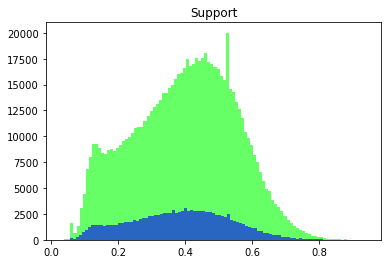

In [58]:
import matplotlib.pyplot as mpl
fig, axes = mpl.subplots(1)
axes.hist(labeled[labeled['type_label'] == 'cg']['support'], bins=100, color=(0,1,0,.6))
axes.hist(labeled[labeled['type_label'] == 'p']['support'], bins=100, color=(0,0,1,.6))
axes.set_title("Support")

In [27]:
np.mean(labeled[labeled['type_label'] == 'cg']['is_supportive']), np.mean(labeled[labeled['type_label'] == 'p']['is_supportive'])

(0.7249161003279541, 0.7685520668264598)

In [37]:
s = labeled.sample(n=100)

In [38]:
Counter(s.type_label)

Counter({'cg': 81, 'p': 13, 'mixed': 6})

In [40]:
s[['body_text', 'type_label', 'support']]

,body_text,type_label,support
4631181,Camp Carefly sounds wonderful. I am so glad y...,cg,0.576127
4849893,"Holly,\nI was able to talk with your mom brief...",cg,0.565911
129226,So happy to hear the great news!! I hope Abby ...,cg,0.681990
5020986,Man it's nice to read that things are going so...,cg,0.462318
5167191,Very interesting updates - regards to Jeff.,p,0.499120
...,...,...,...
1725666,"Bryan and Rachel,\n\nFirst of all thank you fo...",cg,0.439437
2432748,Sending love<3,cg,0.475849
5624569,Praying...and loving camp crazy. &nbsp;Keep th...,cg,0.862441
4928846,It looks like you guys will still be there on ...,cg,0.466292


In [42]:
s.to_csv("intension_annotations.csv")